In [1]:
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
from pafi import ResultsProcessor

## Example usage

In [2]:
# Here, we know the actual min/max lattice constant. TODO: read this in...
strain_min, strain_max = -3.0,+7.0 # in percent

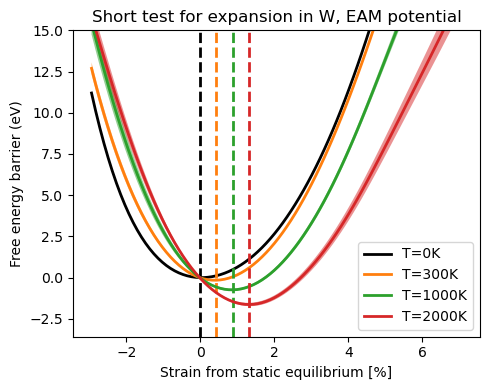

In [3]:

p = ResultsProcessor(   data_path=glob("dumps/pafi_data_*.csv"),
                        xml_path='dumps/config_0.xml', integrate=True)

# integrate once
plotting_data,x_key,y_key = p.plotting_data()

# find 0K minimum
i_start = plotting_data[0][y_key].argmin()

# integrate all data from this minimum (inc. error bars)
plotting_data,x_key,y_key = p.plotting_data(starting_point=plotting_data[0][x_key][i_start])

# Plotting
fig = plt.figure(figsize=(5,4))
ax = fig.add_subplot(111)
ax.set_title("Short test for expansion in W, EAM potential")

for i,row in enumerate(plotting_data):
    # Plotting data    
    x,y,e = row[x_key], row[y_key], row[y_key+"_err"]
    T = int(row['Temperature'])
    #label = r"$\Delta\mathcal{F}$=%2.2f±%2.2f eV, T=%dK"% (y.max(),e.max(),T)
    label = r"T=%dK"% (T)
    
    strain = np.linspace(strain_min,strain_max,x.size)
    strain += (strain[1]-strain[0])/2.0 # integration correction
    # make plots
    if i==0:
        c='k'
    else:
        c=f'C{i}'
    ax.fill_between(strain,y-e,y+e,facecolor=c,alpha=0.5)
    ax.plot(strain,y,f'{c}-',lw=2,label=label)
    ax.axvline(strain[y.argmin()],lw=2,ls='--',color=c)
# save
ax.set_ylim(ymax=15)
ax.legend(loc='best')
ax.set_xlabel("Strain from static equilibrium [%]")
ax.set_ylabel("Free energy barrier (eV)")

plt.tight_layout()
plt.savefig("../test_output.png",dpi=300)


## In depth usage

We have data from independent PAFI runs for the same system at `dumps/pafi_data_*.csv`

In this test, all data is at zero temperature, with only one sampling step. 
This is to ensure reproducibility and fast testing.

We first read in all data files and collate.

To perform integration, we must specify which of the fields in the PAFI data file
are marginal constraints for the sampling. 

In the standard PAFI these are `ReactionCoordinate` and `Temperature`,
but we could also have an additional argument e.g. `Stress`, using the `Custom` feature (see examples)

This is specified in the `<Axes>` section of the `config_*.xml` configuration file. 
If no configuration file is given, we can pass a list of keys as an argument `axes`, 
or just use the default values `[ReactionCoordinate, Temperature]`

We now perform intergation of some target field, default is clearly the average free energy profile `FreeEnergyGradient`, 
with respect to some argument, default is clearly the reaction coordinate `ReactionCoordinate`

**N.B. we are using test data here, at zero temperature with only one sampling step- this is why `SampleSteps`=1, etc**

In [4]:
x_key = 'ReactionCoordinate'
y_key = 'FreeEnergyGradient'

integrated_data, plotting_data = p.integrate(  remesh=10,
                                            return_remeshed_array=True,
                                            target=y_key,argument=x_key)

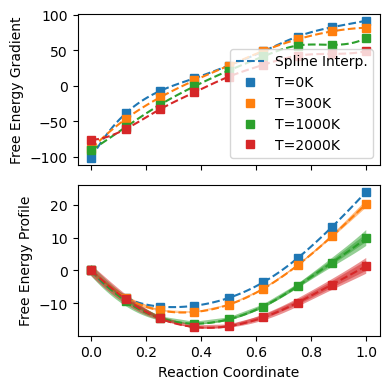

In [5]:
y_key_integ = y_key+"_integrated"
y_key_integ_err = y_key+"_integrated_err"

fig,axs = plt.subplots(2,1,figsize=(4,4),sharex=True)


print_label = True

for i,row in enumerate(plotting_data):
    axs[0].plot(row[x_key],
                    row[y_key],f'C{i}--',
                    label='Spline Interp.' if print_label else None
                    )
    
    axs[1].fill_between(row[x_key],
                    row[y_key_integ]-row[y_key+"_err"],
                    row[y_key_integ]+row[y_key+"_err"],
                    facecolor=f'C{i}',alpha=0.5,
                    label='Spline Interp.' if print_label else None
                    )
    
    axs[1].plot(row[x_key],
                    row[y_key_integ],f'C{i}--',
                    label='Spline Interp.' if print_label else None
                    )
    
    print_label = False

for i,t in enumerate(np.sort(integrated_data['Temperature'].unique())):
    select_data = integrated_data[integrated_data['Temperature']==t]

    axs[0].plot(select_data[x_key],select_data[y_key],
                    f'C{i}s',label=f'T={int(t)}K')
    
    axs[1].fill_between(select_data[x_key],
                    select_data[y_key_integ]-select_data[y_key_integ_err],
                    select_data[y_key_integ]+select_data[y_key_integ_err],
                    facecolor=f'C{i}',alpha=0.5,
                    label='Spline Interp.' if print_label else None
                    )    
    axs[1].plot(select_data[x_key],select_data[y_key_integ],
                    f'C{i}s',label=f'T={int(t)}K')

axs[0].set_ylabel("Free Energy Gradient")
axs[1].set_ylabel("Free Energy Profile")
axs[1].set_xlabel("Reaction Coordinate")

axs[0].legend()
plt.tight_layout()